# 在无标记数据集上进行预训练

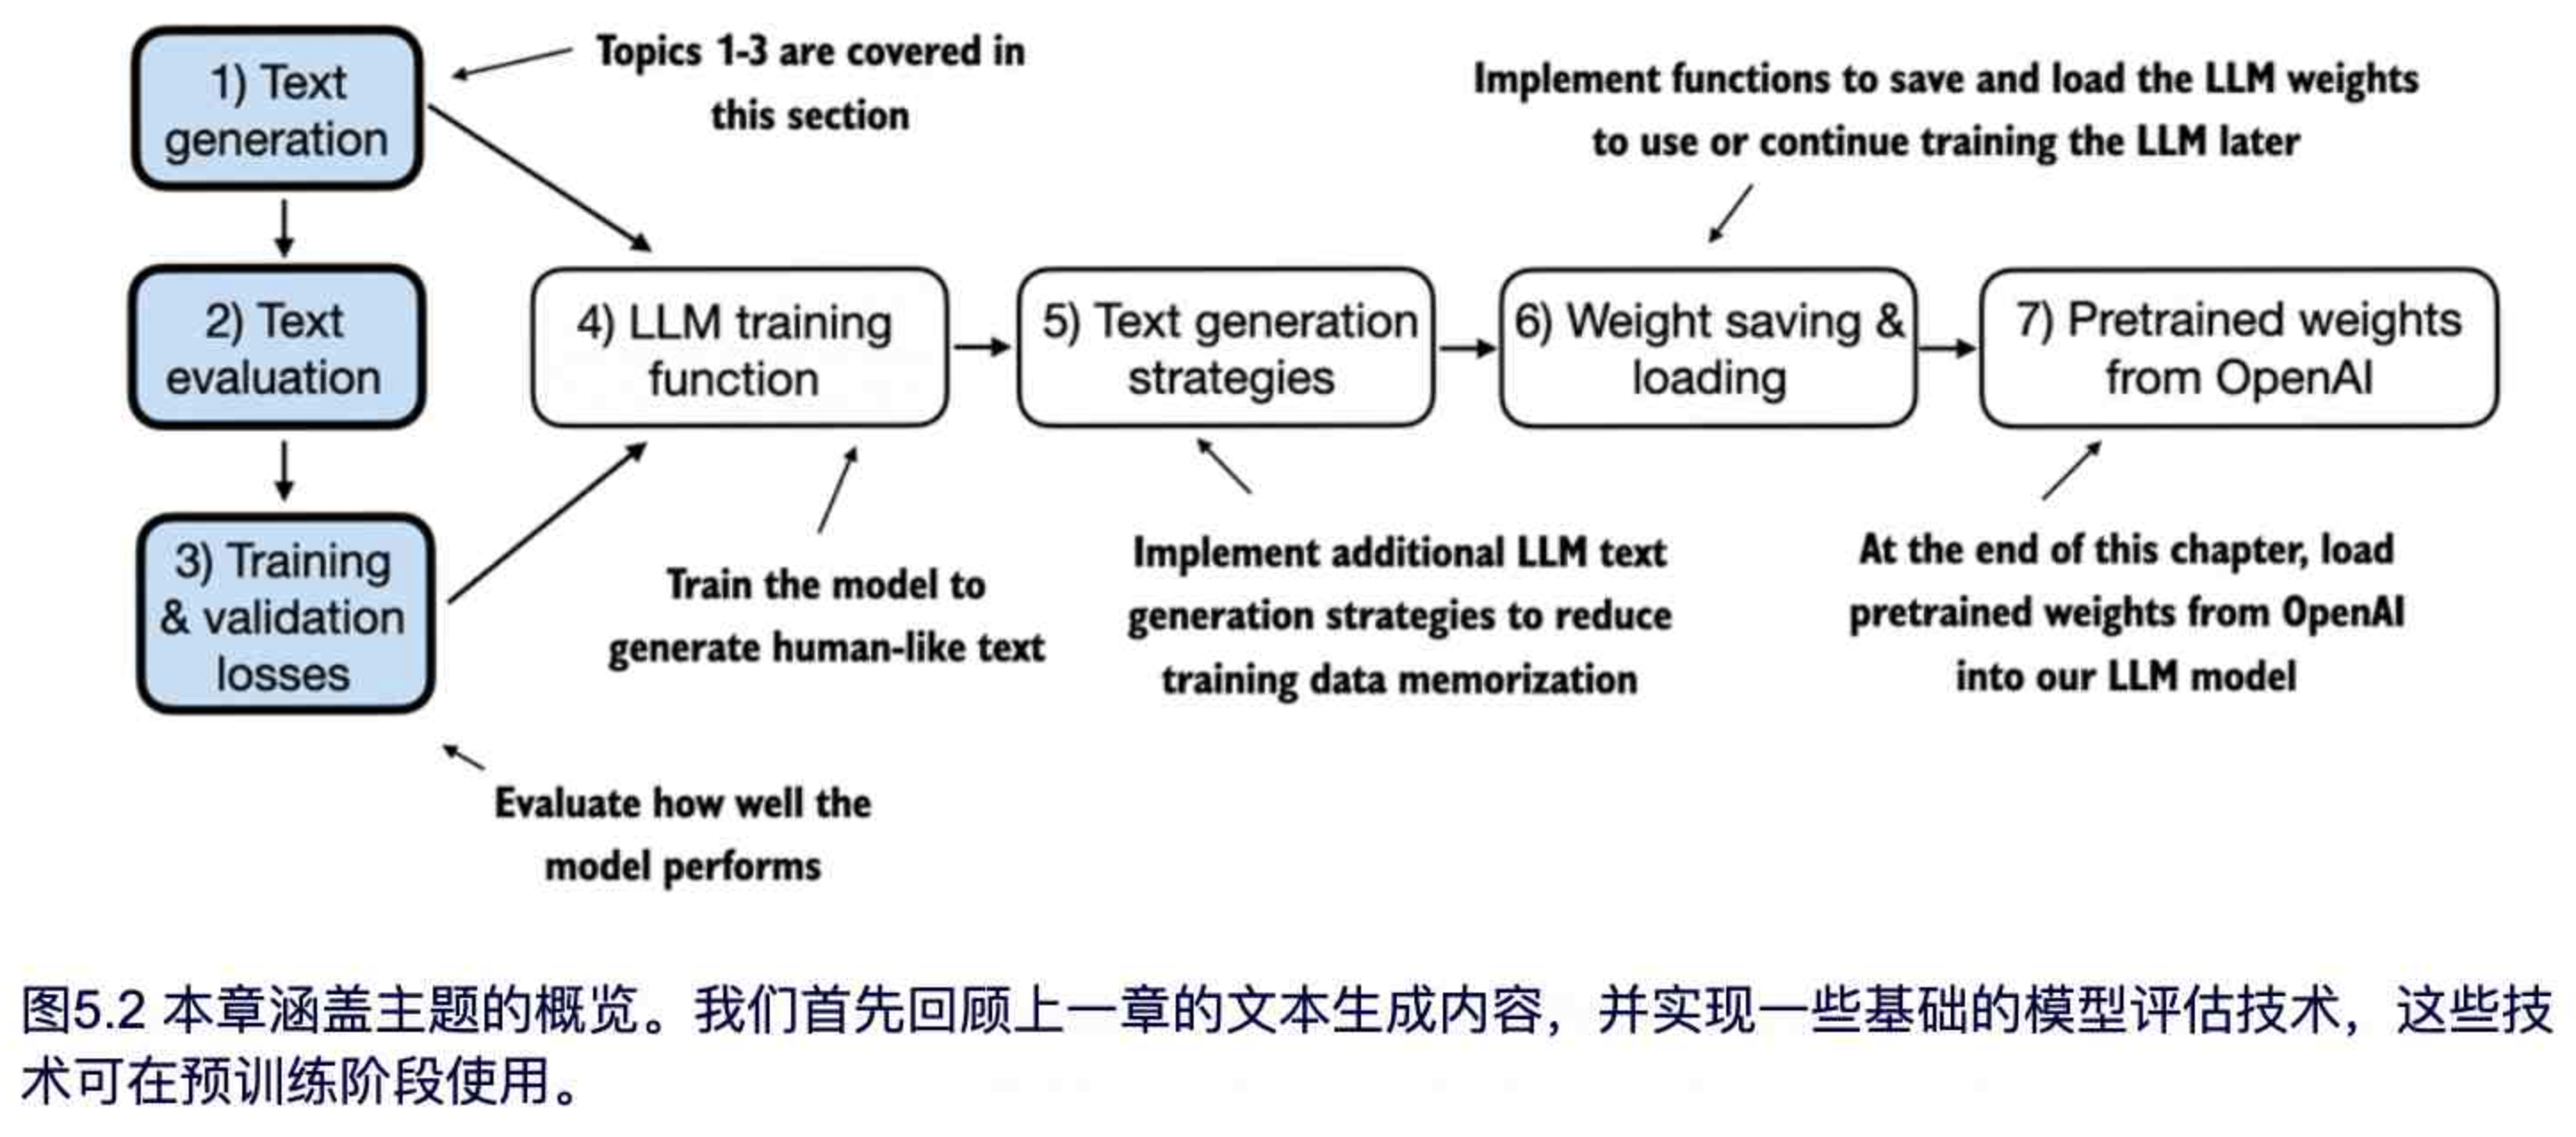
## 生成式文本模型的评估

In [1]:
import torch
from model import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
text_x = torch.randint(0, 50257, (2, 4))
print(model(text_x).shape)

torch.Size([2, 4, 50257])


In [3]:
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

'''
| 写法                  | 输出形状                   | 含义                           |
| ------------------- | ---------------------- | ---------------------------- |
| `logits[:, -1, :]`  | **(b, vocab_size)**    | 取出最后一个时间步的向量，并“压掉”时间维        |
| `logits[:, -1:, :]` | **(b, 1, vocab_size)** | 取出最后一个时间步，但**保留时间维度**（长度为 1） |

'''


def generate_text_example(model, idx, max_new_tokens, context_size):
    #idx -> b, seq_len
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond) #[b, seq_len, 50257]
        
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.concat((idx, idx_next), dim=-1)
    
    return idx
        
        
        
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_example(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## 文本生成损失计算  
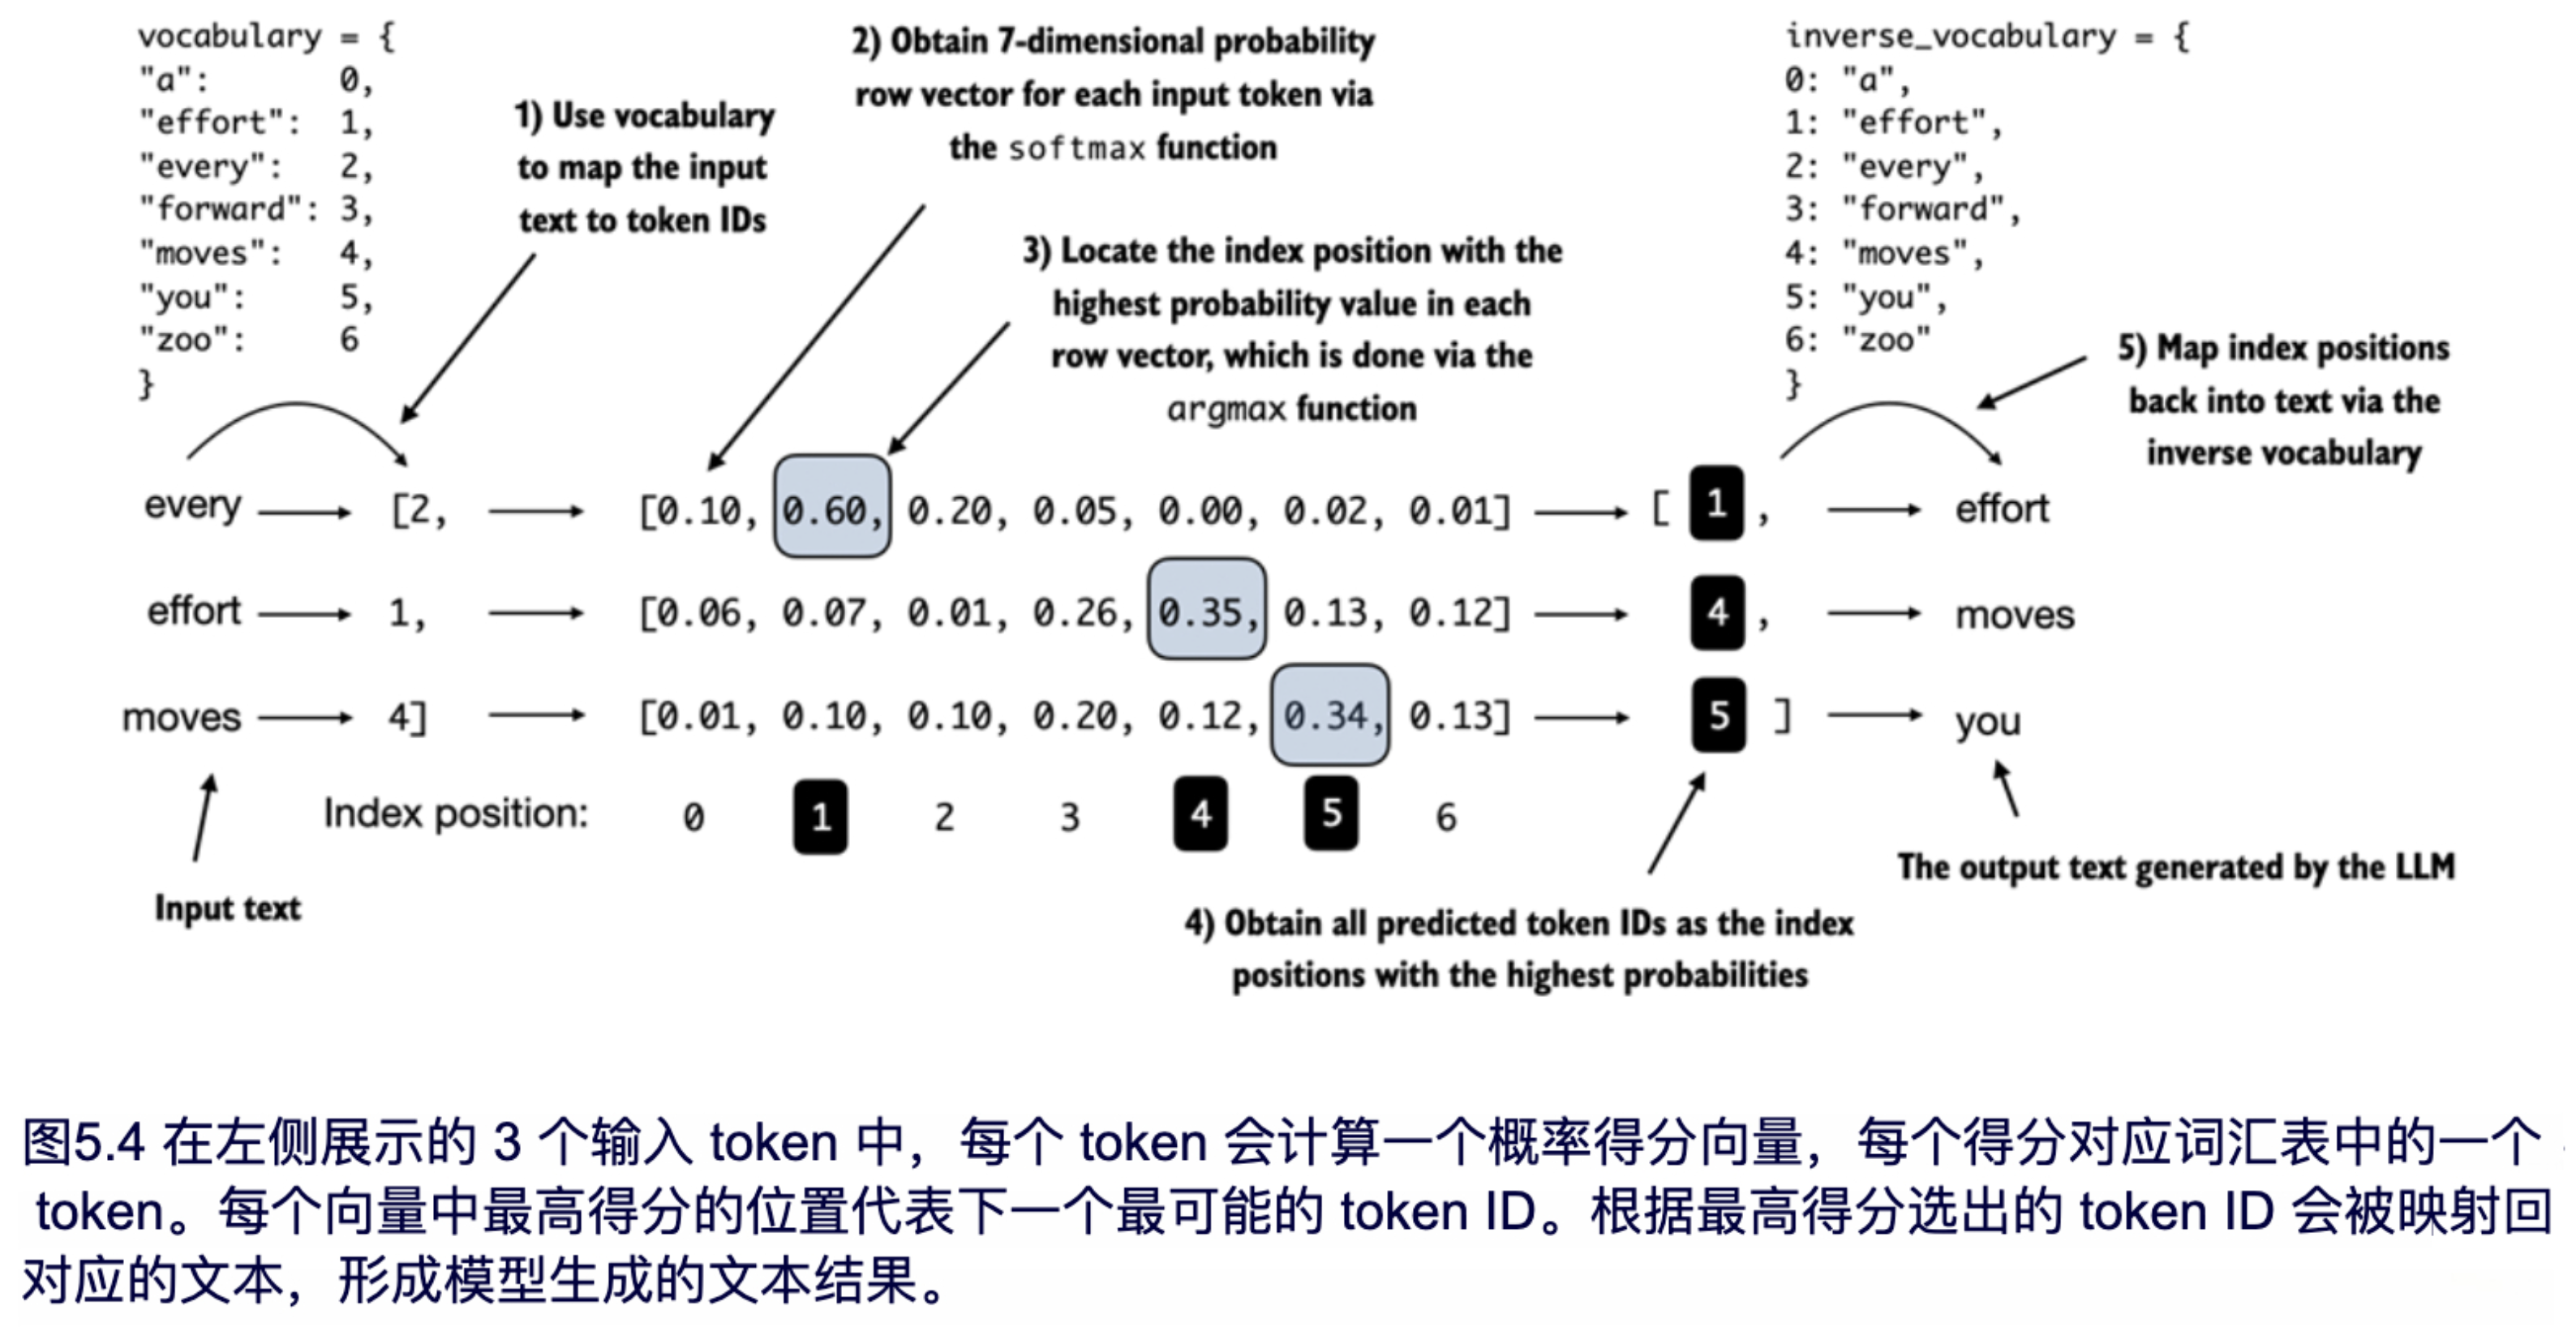

In [28]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]
with torch.no_grad():
    logits = model(inputs)
    probas = torch.softmax(logits, dim=-1)

print(probas.shape)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)
print(f"Target:{token_ids_to_text(targets[0], tokenizer=tokenizer)}")
print(f"Output:{token_ids_to_text(token_ids[0].flatten(), tokenizer=tokenizer)}")
print(logits.shape, targets.shape)

torch.Size([2, 3, 50257])
tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Target: effort moves you
Output: Armed heNetflix
torch.Size([2, 3, 50257]) torch.Size([2, 3])


In [29]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)
#训练 LLM 的目标就是最大化这些概率值，使其尽量接近 1。
# 这样可以确保 LLM 始终选择目标 token —— 即句中的下一个词，作为生成的下一个 token。

Text 1: tensor([7.4536e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6771e-05, 4.7559e-06])


In [30]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7765, -12.2561])


In [31]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [32]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print(logits_flat.shape, targets_flat.shape)

torch.Size([6, 50257]) torch.Size([6])


这里涉及到了Cross_entropy的概念 cross_entropy首先会将输入的logits_flat进行一个softmax得到概率然后根据target_flat做为  
目标索引进行比对然后计算损失，说人话就是取出logits_flat[targets_flat[0]] 计算一个交叉熵损失 然后算平均

In [ ]:

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [34]:
##计算训练集和验证集的损失
# 使用我们在第 2 章中使用的《判决》短篇小说
file_path = 'the-verdict.txt'
with open (file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
#A:对文本进行编码
#B:创建input -> target对
#C:返回数据集长度和指定行
class GPTDatasetv1(Dataset):
    def __init__(self, text, tokenizer, context_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids)-context_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i : i + context_length]))
            self.target_ids.append(torch.tensor(token_ids[i+1 : i+1+context_length]))
    
    def __len__(self):
        return(len(self.input_ids))
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

#根据数据集建立Dataloader

def create_dataloader(text, tokenizer, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    dataset = GPTDatasetv1(text, tokenizer, context_length=max_length,stride=stride)
    dataloader = DataLoader(dataset=dataset, 
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)
    
    return dataloader

In [36]:
torch.manual_seed(123)
train_ratio = 0.9
split_idx = int(total_characters*train_ratio)
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]
train_loader = create_dataloader(
    text = train_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader(
    text=val_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [37]:
def cal_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(input=logits.flatten(0,1), target=target_batch.flatten())
    return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)                                    #A
    else:
        num_batches = min(num_batches, len(data_loader))   #B
    
    for i,(input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            total_loss+=loss
        else:
            break
        
    total_loss = loss / num_batches
    return total_loss
    

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
with torch.no_grad():
    train_loss = cal_loss_loader(train_loader, model, device)
    val_loss = cal_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(1.2219, device='cuda:0')
Validation loss: tensor(10.9811, device='cuda:0')


## 训练LLM  
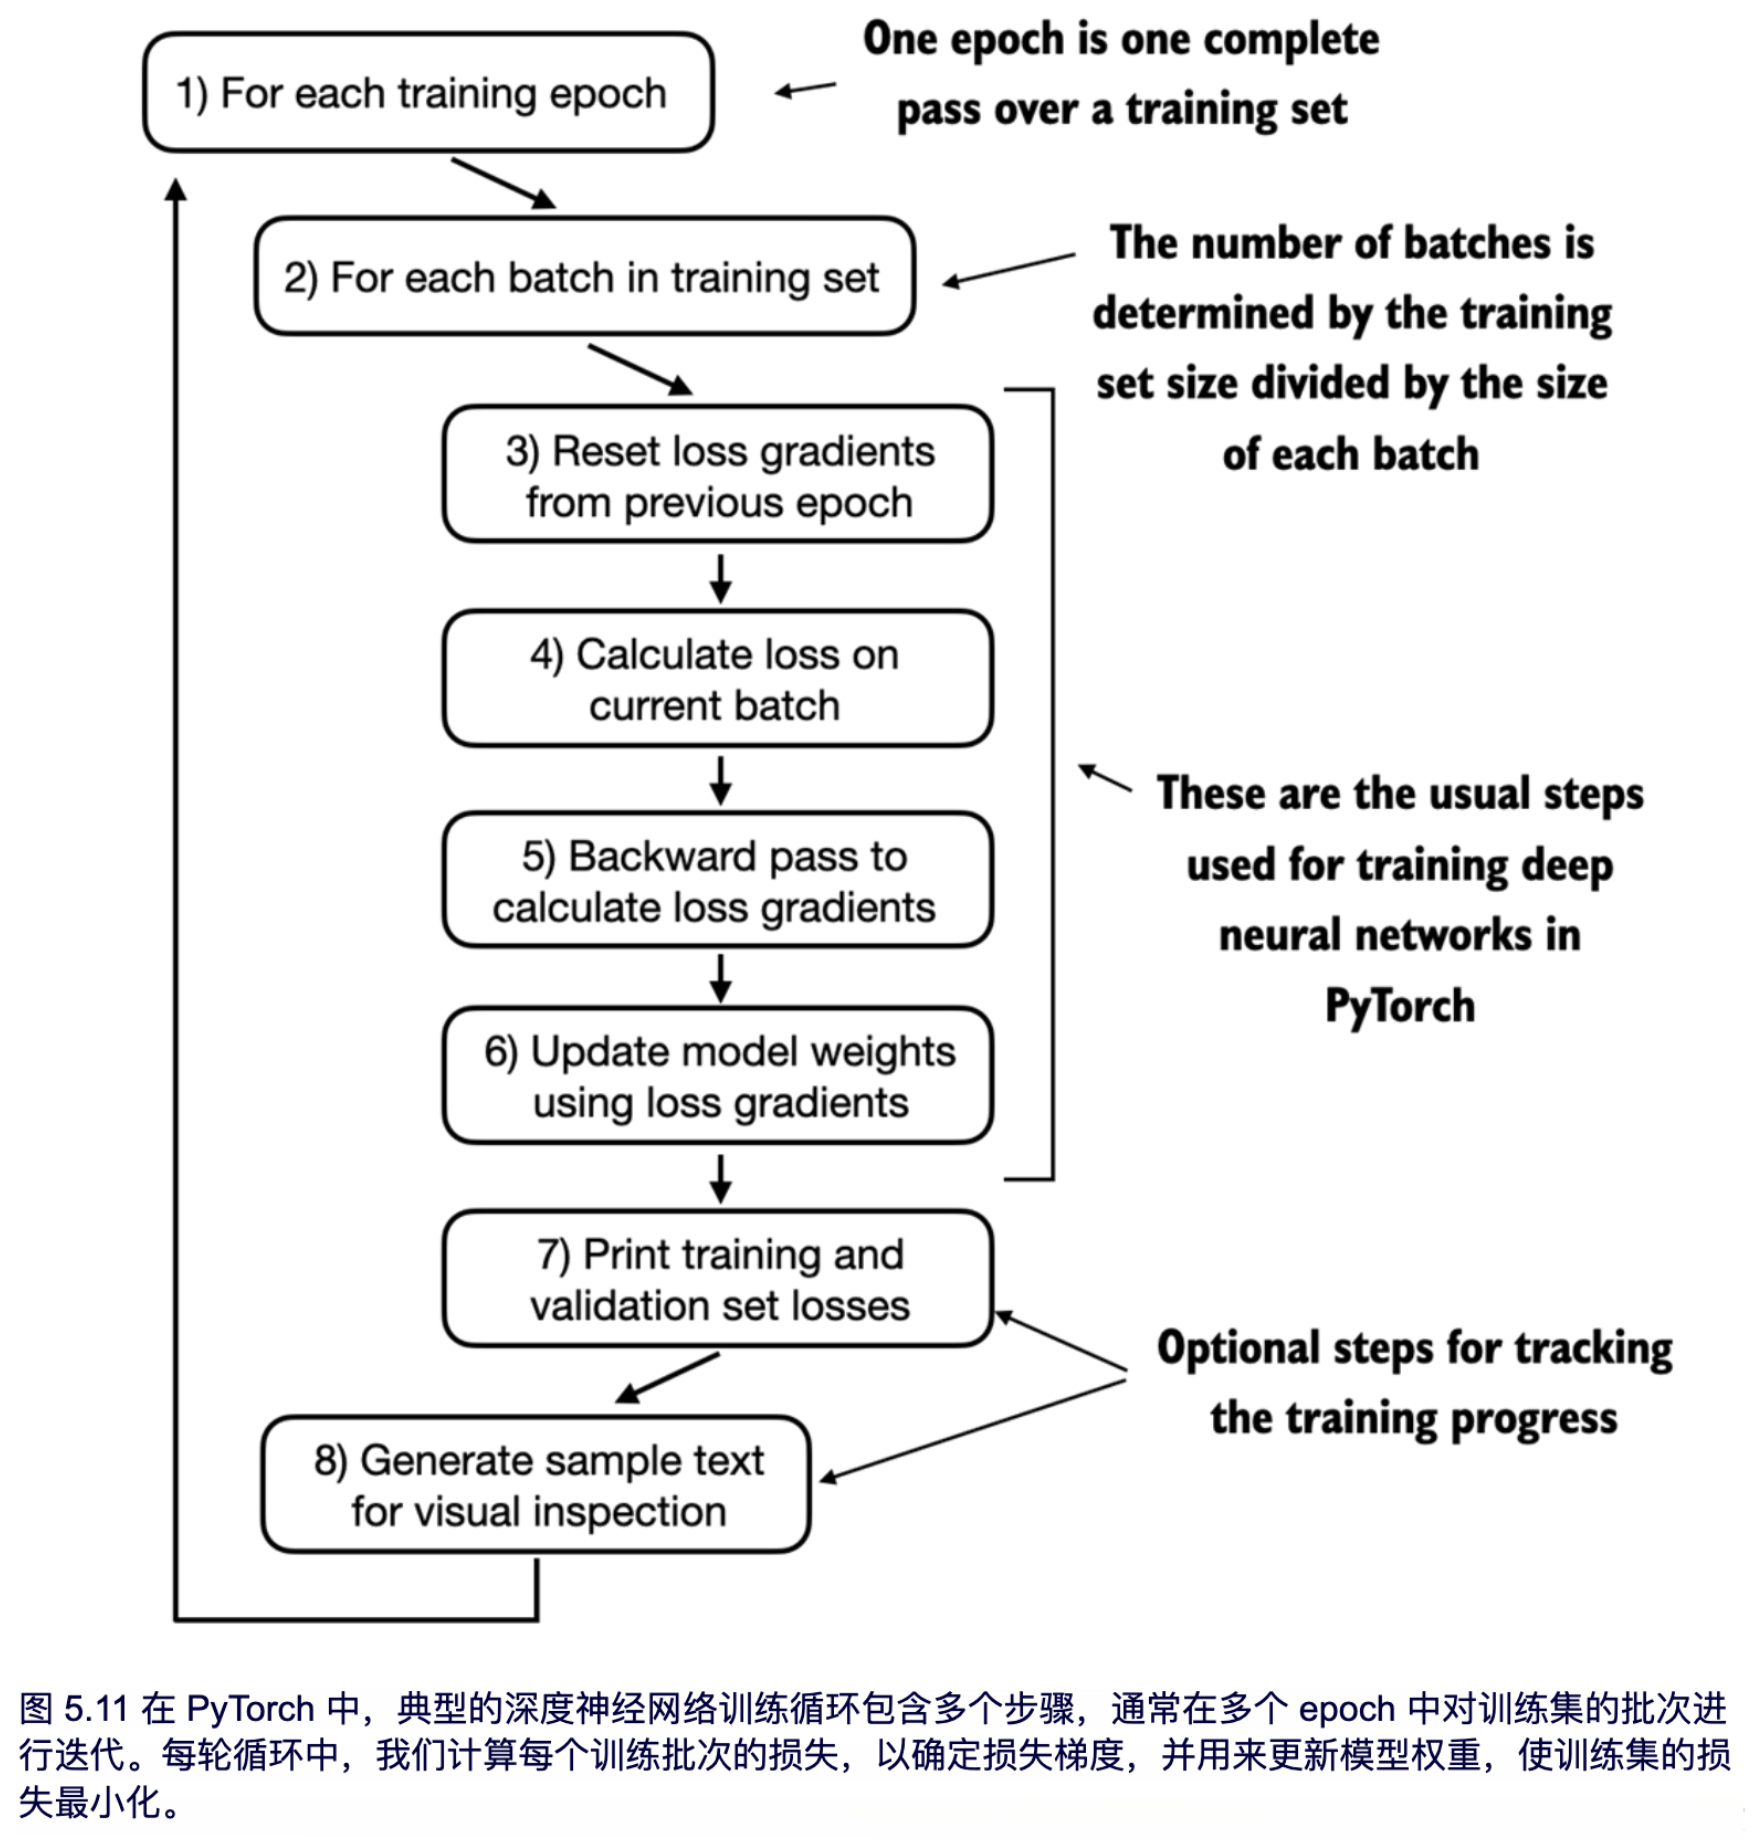

In [43]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = cal_loss_loader(train_loader, model, device, eval_iter)
        val_loss = cal_loss_loader(val_loader,model,device, eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_example(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = cal_loss_batch(input_batch, target_batch,model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq ==0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                generate_and_print_sample(                                                  #G
            model, tokenizer, device, start_context
        )
        
    return train_losses, val_losses, track_tokens_seen
            

In [44]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
epochs=10
train_losses, val_losses, track_tokens_seen = train_model_simple(model,train_loader,val_loader,optimizer,device,epochs, 
                                                                 eval_freq=5,eval_iter=1,start_context="Every effort moves you",tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 10.059, Val loss 9.931
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the the,,,,,,,,,,,,,,,,,,,
Ep 1 (Step 000005): Train loss 8.160, Val loss 8.334
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000010): Train loss 6.555, Val loss 7.049
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000015): Train loss 5.922, Val loss 6.598
Every effort moves you, the, the the the, the the the, the the the.                                   
Ep 3 (Step 000020): Train loss 5.833, Val loss 6.503
Every effort moves you, and, and the a.                     """-- the of the of the's the", and the of the of the"I the
Ep 3 (Step 000025): Train loss 5.410, Val loss 6.393
Every effort moves you, and I had to the of the his to the's.                      

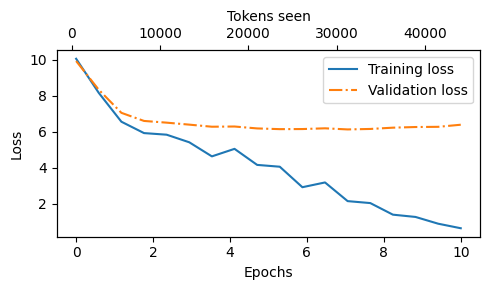

In [49]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # ✅ 确保所有输入都在 CPU 上
    def to_numpy(x):
        if torch.is_tensor(x):
            return x.detach().cpu().numpy()
        elif isinstance(x, list) and torch.is_tensor(x[0]):
            return [t.detach().cpu().item() for t in x]
        return x

    epochs_seen = to_numpy(epochs_seen)
    tokens_seen = to_numpy(tokens_seen)     # ← 关键补充！
    train_losses = to_numpy(train_losses)
    val_losses = to_numpy(val_losses)

    # 绘图
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # 第二个横轴
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

#A 创建与 y 轴共用的第二个 x 轴
#B 用于对齐刻度的隐藏图形


## 通过解码策略控制生成结果的随机性

In [50]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_example(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [52]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(-1)
            logits = torch.where(logits < min_val,
                                 torch.tensor(float('-inf')).to(logits.device),
                                 logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if eos_id is not None and (idx_next == eos_id).any():
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx



#A For循环与之前相同：获取logits，仅关注最后的时间步
#B 在新步骤中，通过top-k采样过滤logits
#C 在新步骤中应用temperature scaling
#D 在未使用temperature scaling时，执行贪婪的下一个token选择
#E 如果遇到序列结束token且指定了eos_id，则提前停止生成


In [55]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device='cpu'),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves youlit," she up surprise. It is to face watching me by his knees


## 保存权重  

In [56]:
torch.save(model.state_dict(), "model.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_norm): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (LN1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (LN2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Tra